![baby beluga](https://drivendata-public-assets.s3.amazonaws.com/boem-beluga-pod.jpeg)

Welcome to the benchmark notebook for the **Where's Whale-do?** competition! 

If you are just getting started, first checkout the competition [homepage](https://www.drivendata.org/competitions/96/beluga-whales/) and [problem description](https://www.drivendata.org/competitions/96/beluga-whales/page/479/).

## Where's Whale-do?

Cook Inlet beluga whales are at risk of extinction. This beluga population began declining in the 1990s due to overhunting and currently contains less than 300 surviving individuals. As a result, NOAA Fisheries conducts an annual photo-identification survey to more closely monitor and track individual whales. This is where we need your help!

The goal of this $35,000 challenge is to help wildlife researchers accurately match beluga whale individuals from photographic images. Accelerated and scalable photo-identification is critical to population assessment, management, and protection of this endangered whale population.

**For this competition, you will be identifying which images in a database contain the same individual beluga whale seen in a query image.**

You will be provided with a set of queries, each one specifying a single image of a beluga whale and a corresponding database to search for matches to that same individual. The database will include images of both matching and non-matching belugas. This is a learning-to-rank information retrieval task.

This notebook covers two main areas:

- [**Section 1. Data exploration:**](#data-exploration): An introduction to the beluga images dataset, including examples of the different image types and visual features to be aware of.

- [**Section 2. Demo submission:**](#demo-submission) A demonstration of how to run the benchmark example and produce a valid code submission.

<a id="data-exploration"></a>

## Section 1: Data exploration

### Download the data

First, download the `images` and `metadata.csv` files from the [competition website](https://www.drivendata.org/competitions/96/beluga-whales/data/).

Save the files in the `data` directory so that your tree looks like this. 
```
boem-belugas-runtime/             # This repository's root
└── data/                         # Competition data directory
    ├── databases/                # Directory containing the database image IDs for 
    │      │                          each scenario
    │      ├── scenario01.csv
    │      └── scenario02.csv
    ├── images/                   # Directory containing all the images
    │      ├── train0001.jpg
    │      ├── train0002.jpg
    │      ├── train0003.jpg
    │      └── ...
    ├── queries/                  # Directory containing the query image IDs for 
    │      │                          each scenario
    │      ├── scenario01.csv
    │      └── scenario02.csv
    ├── metadata.csv              # CSV file with image metadata (image dimensions, 
    │                                 viewpoint, date)
    └── query_scenarios.csv       # CSV file that lists all test scenarios with paths
```

If you're working off a clone of this [runtime repository](https://github.com/drivendataorg/boem-belugas-runtime), you should already have copies of the `databases`, `queries` and `query_scenarios.csv` files.

### Explore the data
First, let's load a couple of the data files we just downloaded. Initially we are just going to be focused on the `metadata` file.

In [1]:
from pathlib import Path

import pandas as pd

PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
SUBM_DIRECTORY = PROJ_DIRECTORY / "submission"

metadata = pd.read_csv(DATA_DIRECTORY / "metadata.csv", index_col="image_id")
query_scenarios = pd.read_csv(DATA_DIRECTORY / "query_scenarios.csv", index_col="scenario_id")

#### Look at some sample images
Let's begin by looking at some images with our regular old human eyes, before handing things over to the computer.

The function below shows a random sample of images (change `random_state` to get a new set) for a given viewpoint. 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(viewpoint="top", random_state=1, metadata=metadata):
    # set plot layout depending on image viewpoint
    nrows, ncols = (1, 5) if viewpoint == "top" else (4, 2)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
    # get a random sample of images
    sample = metadata[metadata.viewpoint == viewpoint].sample(nrows*ncols, random_state=random_state)
    # plot in grid
    for img_path, ax in zip(sample.path, axes.flat):
        img = mpimg.imread(DATA_DIRECTORY / img_path)
        ax.imshow(img)    

Let's look at a random sample of "top" images, taken from overhead by drone. Note the differences in color, marks and scarring, as well as which regions of the body are visible. Also note that other factors like the water and lighting conditions can affect the quality of the image.

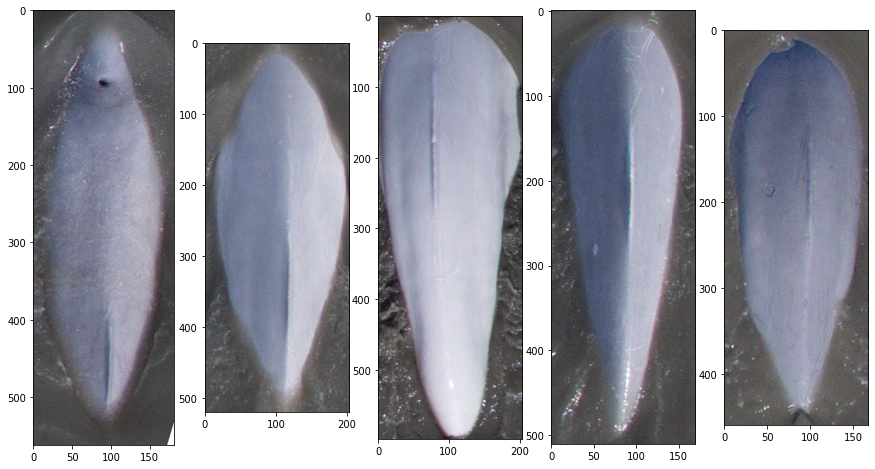

In [3]:
display_images("top", random_state=1)

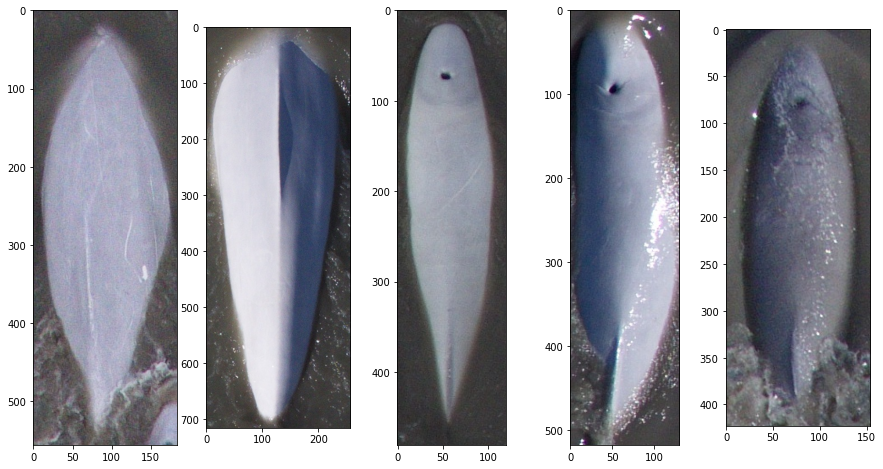

In [4]:
display_images("top", random_state=2)

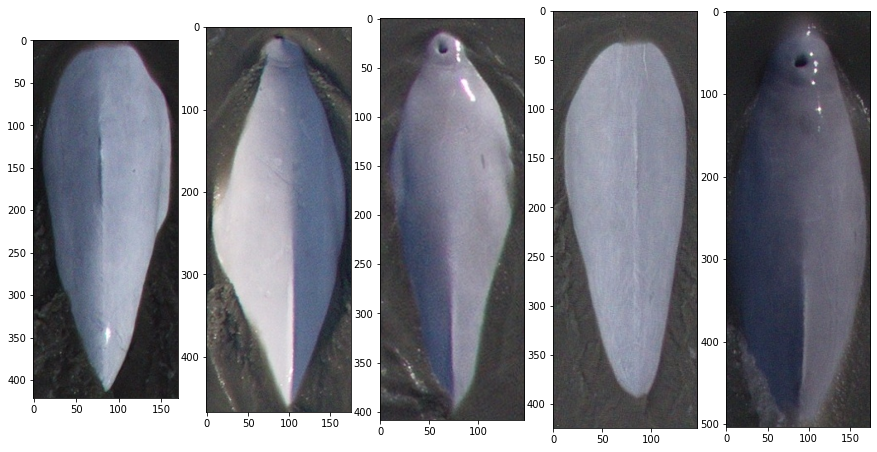

In [5]:
display_images("top", random_state=3)

Most images in the dataset (92%) are taken from overhead like the ones above. But there are also some "lateral" images that are taken from vessels. These images have a viewpoint of either `"left"` or `"right"`.

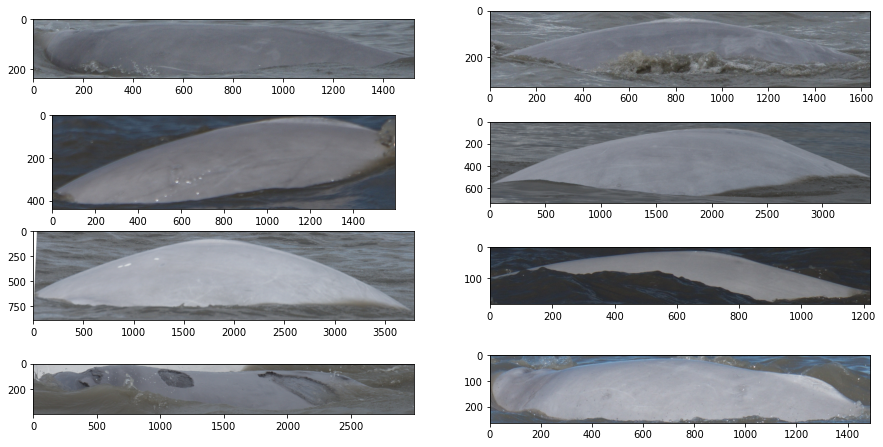

In [6]:
display_images("left", random_state=1)

In [7]:
metadata.viewpoint.value_counts()

top      5434
left      237
right     231
Name: viewpoint, dtype: int64

#### Dataset summary
In total, there are **5902 images** in the training dataset, and **788 unique whale IDs**. 

Whale IDs identify individual belugas, though an individual can have more than one whale ID over its lifetime due to changes in its appearance over time. Check out the [Problem Description](https://www.drivendata.org/competitions/96/beluga-whales/page/479/#whale_id) for a more detailed discussion of whale IDs, if you haven't already.

In [8]:
print(f"n images:    {len(metadata)}")
print(f"n whale IDs: {metadata.whale_id.nunique()}")

n images:    5902
n whale IDs: 788


#### Image dimensions
The height and width of the images vary. "Top" images tend to be "tall", while lateral images tend to be "wide". Let's take a quick look at the distribution of image dimensions.

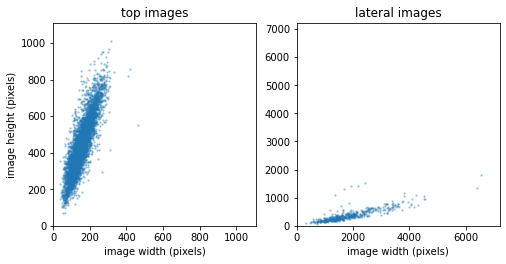

In [9]:
def plot_image_dims(metadata, ax, title=None, ylabel=True):
    lim = max(metadata.width.max(), metadata.height.max())*1.1    
    ax.scatter(metadata.width, metadata.height, s=2, alpha=0.3)
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    ax.set_xlabel('image width (pixels)')
    if ylabel:
        ax.set_ylabel('image height (pixels)')
    ax.set_aspect('equal')
    ax.set_title(title)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plot_image_dims(metadata[metadata.viewpoint == "top"], axes[0], title="top images")
plot_image_dims(metadata[metadata.viewpoint != "top"], axes[1], title="lateral images", ylabel=False)

Note that the two plots do not share axes. The lateral images are generally much wider, with a handful that are "extra wide".

#### Matches
As noted above, we can use the `whale_id` data to identify images of the same whale.

Typically we'll have between 2-6 distinct images of most whales. But in some cases we may have just one image of a given whale, and in other cases we have many more (>100).

1     155
2     161
3      89
4      57
5      41
6      53
7      27
8      25
9      11
10     16
dtype: int64


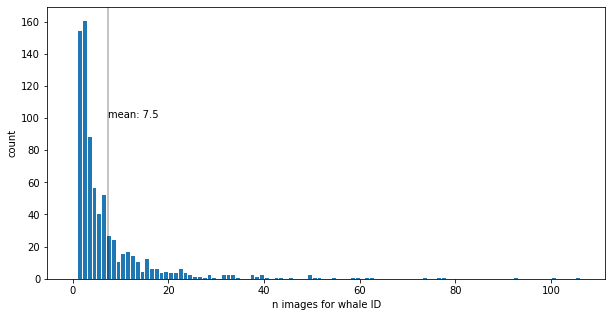

In [10]:
whale_id_counts = metadata.groupby("whale_id").size()

whale_id_counts.hist(bins=range(107), grid=False, figsize=(10,5), edgecolor="white")
plt.axvline(whale_id_counts.mean(), color='k', alpha=0.3)
plt.text(whale_id_counts.mean(), 100, s="mean: {:.1f}".format(whale_id_counts.mean()))
plt.xlabel("n images for whale ID")
plt.ylabel("count")

print(whale_id_counts.value_counts().sort_index().head(10))

#### Match examples
Here is a sample of images from `whale093`, which has the most images (106) of any individual in the dataset. Note the similarity in color and the distinctive notch in this whale's dorsal fin.

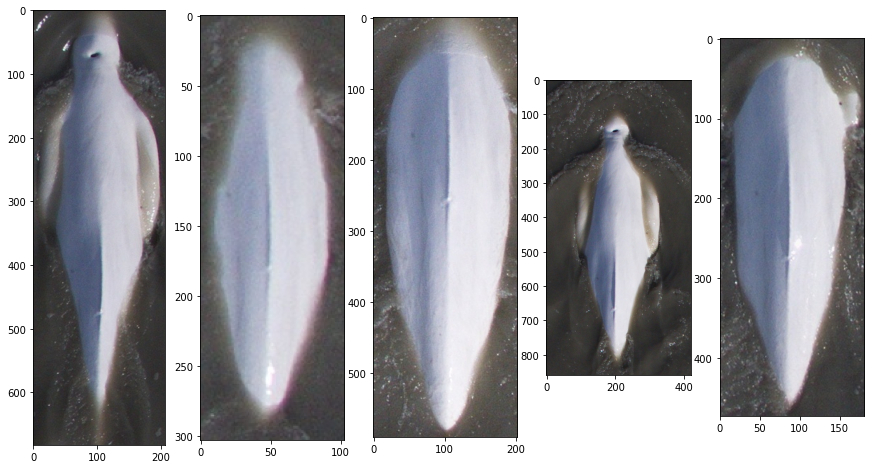

In [11]:
metadata_individual = metadata[metadata.whale_id == "whale093"]
display_images("top", metadata=metadata_individual, random_state=1)

Let's look at some other sets of matching images for a given whale to get a sense for the visual features that make an individual beluga identifiable.

We'll restrict ourselves to "top" images for now to keep things simple, and we'll look at whales that have at least 5 images so we can get an idea for how these matches can vary.

In [12]:
whale_id_counts_top = metadata[metadata.viewpoint=="top"].groupby("whale_id").size()
whales_with_5_top_images = whale_id_counts_top[whale_id_counts_top >= 5]
whales_with_5_top_images.index

Index(['whale001', 'whale003', 'whale004', 'whale005', 'whale007', 'whale008',
       'whale009', 'whale010', 'whale011', 'whale012',
       ...
       'whale581', 'whale587', 'whale611', 'whale612', 'whale617', 'whale643',
       'whale669', 'whale676', 'whale696', 'whale702'],
      dtype='object', name='whale_id', length=289)

whale206


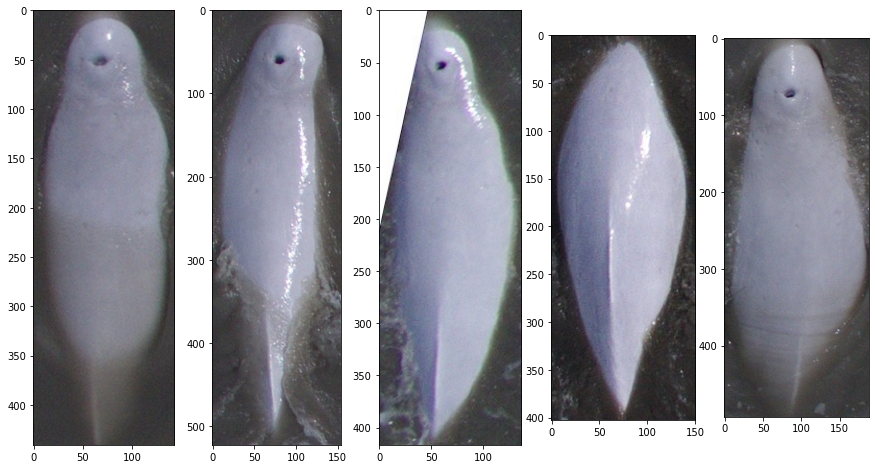

In [13]:
whale_id = whales_with_5_top_images.sample(1, random_state=1).index[0]
display_images("top", metadata=metadata[metadata.whale_id == whale_id])
print(whale_id)

The indentations around the blowhole of this beluga (whale206, above) are probably its most identifiable feature.

whale010


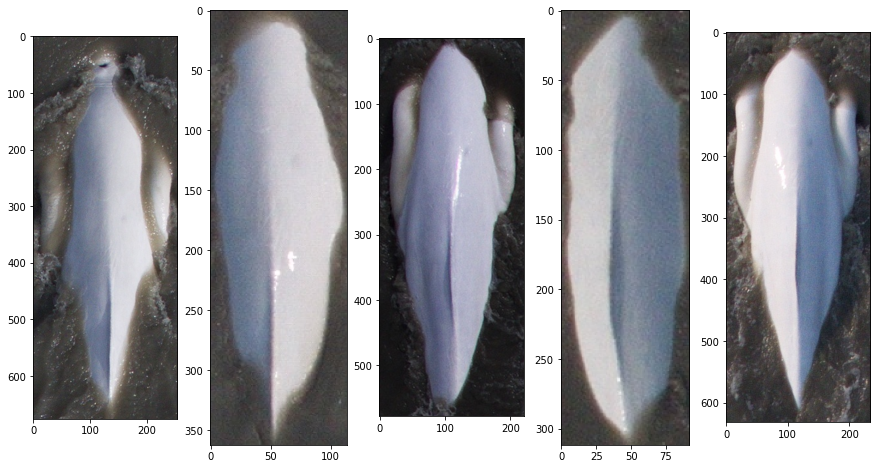

In [14]:
whale_id = whales_with_5_top_images.sample(1, random_state=2).index[0]
display_images("top", metadata=metadata[metadata.whale_id == whale_id])
print(whale_id)

This beluga (whale010) has some light scratches near the top of its dorsal fin, but they are very subtle.

whale145


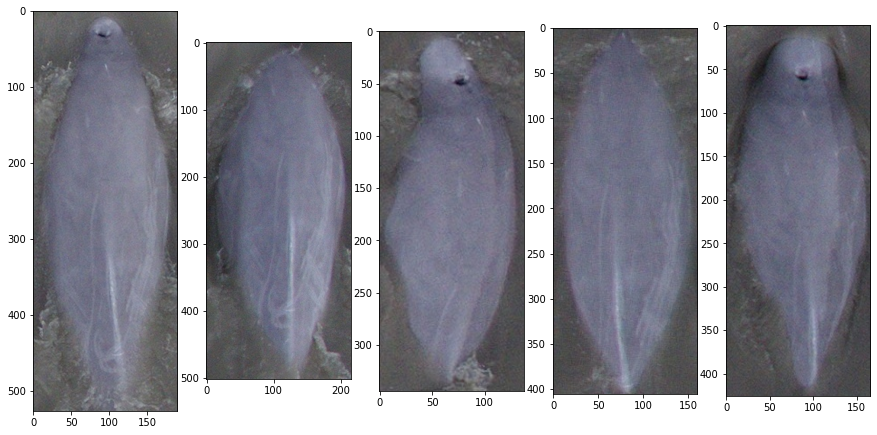

In [15]:
whale_id = whales_with_5_top_images.sample(1, random_state=3).index[0]
display_images("top", metadata=metadata[metadata.whale_id == whale_id])
print(whale_id)

The scratches along the back and some distinctive features around the blowhole distinguish this beluga (whale145).

#### Cropped images
You may have noticed that some images contain triangular regions of white space. This occurs because the original photos of these belugas are taken with a much wider field of view that may contain multiple belugas, before being passed through an auto-detection algorithm that identifies each individual beluga whale and draws a bounding box around it. 

When these bounding boxes happen to overlap with the edges of the original photo, the region of the box for which we have no data (it is beyond the original image's border) are encoded as white pixels.

#### Encounters
Some images in the dataset for a given whale may be very similar to other images of the same whale taken seconds or minutes apart. In order to facilitate training your model on data that is representative of the task, we have provided the columns `encounter_id` and `timestamp` (in the training set only) to help inform selection of images. The `encounter_id` column has been generated per-individual-whale by associating runs of images of the whale that are separated by a short amount of time (1 hour).

Below we show how the overall duration of these encounters can vary.

In [16]:
# convert timestamp column to pandas datetimes
metadata = metadata.assign(timestamp=pd.to_datetime(metadata.timestamp))

Text(0.5, 0, 'encounter duration in minutes')

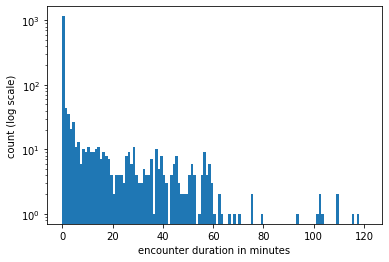

In [17]:
def get_duration_mins(df):
    return (df.timestamp.max() - df.timestamp.min()).seconds / 60

encounter_durations = metadata.groupby('encounter_id').apply(get_duration_mins)
encounter_durations.plot(kind='hist', bins=range(0, int(encounter_durations.max()+1)), logy=True)
plt.ylabel("count (log scale)")
plt.xlabel("encounter duration in minutes")

<a id="demo-submission"></a>

## Section 2: Demo submission
Now that we've had a chance to get familiar with the data, it's time to walk through the steps for creating a competition submission.

This is a **code submission competition**, so our focus for now will be on creating that submission in the correct format, and less so on the quality of the model itself.

If you haven't already read through the following resources, now would be a great time to do that:
* [Code Submission Format page](https://www.drivendata.org/competitions/96/beluga-whales/page/482/): An introduction to the code submission setup and how to make a valid submission.
* [Runtime Repository README](https://github.com/drivendataorg/boem-belugas-runtime): Details on the competition runtime and how to use this repository effectively.

### Download a pretrained model
We'll assume that most if not all participants are going to use a deep learning model for this task, and we'll rely on PyTorch in this example.

Let's begin by downloading a popular pretrained model (we chose ResNet34 but it could be almost anything), and saving it to the **`benchmark_src`** directory. This is the directory that we'll be packaging up and submitting as a zip archive on the competition website later in this example.

```
boem-belugas-runtime/
├── benchmark_src/      <----
├── data/      
├── notebooks/      
└── ...             
```
Think of this ResNet34 model as a (vastly inferior) placeholder for the model you will _eventually_ train yourself. For now, we're assuming that you've done all that training already and are ready to submit your code to the platform for scoring.

In [18]:
import torch
import torchvision.models as models

BENCHMARK_SRC = PROJ_DIRECTORY / "benchmark_src"

model = models.resnet34(pretrained=True)
torch.save(model, BENCHMARK_SRC / "model.pth")

### Three Commands
To run and test the benchmark example, you just need to execute the following 3 commands:

1. [`make pull`](#make-pull)
2. [`make pack-benchmark`](#make-pack-benchmark)
3. [`make test-submission`](#make-test-submission)

These are defined in the project `Makefile` [here](https://github.com/drivendataorg/boem-belugas-runtime/blob/master/Makefile). We'll walk through what each one does now.

<a id="make-pull"></a>

#### **`make pull`** 
Pulls the official version of the competition docker image from the [Azure Container Registry](https://azure.microsoft.com/en-us/services/container-registry/). Having a local version of the competition image allows you to test your submission using the same image that is used during code execution.

There are both CPU and GPU versions of this image available. The `make` command will check whether `nvidia-smi` is available on your machine and then pull the GPU version if it is. You can also set this manually by prefixing the command with the `CPU_OR_GPU` variable like so: `CPU_OR_GPU=gpu make pull`.
   
> **Note:** This command can take a little while to run the first time you pull the image. But after that it will be relatively quick since you'll have all the layers cached locally.

In [19]:
!cd {PROJ_DIRECTORY} && make pull

docker pull boembelugas.azurecr.io/drivendata/belugas-competition:cpu-latest
cpu-latest: Pulling from drivendata/belugas-competition

567cc804: Already exists 
30e5ff08: Already exists 
3d81d1f4: Already exists 
4abefb41: Already exists 
59c9d941: Already exists 
cdc98b8a: Already exists 
c0038f80: Pulling fs layer 
fe5b7d93: Pulling fs layer 
9a742b18: Pulling fs layer 
d5e66795: Pulling fs layer 
ad8b4ba5: Pulling fs layer 
b5c5f0a7: Pulling fs layer 
108df997: Pulling fs layer 
6988efd6: Pulling fs layer 
e54fd6ee: Pulling fs layer 
Digest: sha256:2d9ced46a78be6cb5d5ddc31cad7c1d1cd44c4657e6588761356aec3c7e8f97cKDownloading  210.3MB/1.229GBDownloading  395.2MB/1.229GB
Status: Downloaded newer image for boembelugas.azurecr.io/drivendata/belugas-competition:cpu-latest
boembelugas.azurecr.io/drivendata/belugas-competition:cpu-latest


You should now have a local copy of the docker image, which you can verify by running:

In [20]:
!docker images

REPOSITORY                                              TAG          IMAGE ID       CREATED       SIZE
boembelugas.azurecr.io/drivendata/belugas-competition   cpu-latest   cf05dbf419cc   3 hours ago   4.14GB


<a id="make-pack-benchmark"></a>

#### **`make pack-benchmark`** 
This command simply goes to your `benchmark_src` directory, zips the contents, and writes the zip archive to `submission/submission.zip`.

Since we already downloaded a model above, the `benchmark_src` directory should look like this:
```
boem-belugas-runtime/
└── benchmark_src/
    ├── main.py
    └── model.pth
```

(We'll talk about the `main.py` file in more detail further below.)

In [21]:
!cd {PROJ_DIRECTORY} && make pack-benchmark

cd benchmark_src; zip -r ../submission/submission.zip ./*
  adding: main.py (deflated 64%)
  adding: model.pth (deflated 7%)


> **Note:** The `make pack-benchmark` command will check to see if you already have a `submission/submission.zip` and error if you do, so as not to overwrite existing work. If you already have this file, you'll need to manually remove it before running the command.

After running the above command, we should now have a new **`submission/submission.zip`**.
```
boem-belugas-runtime/
├── benchmark_src/
│   ├── main.py
│   └── model.pth
└── submission/
    └── submission.zip   <----    
```

This is the file that we will eventually upload to the competition platform for code execution, but before doing that, we want to test it locally.

<a id="make-test-submission"></a>

#### **`make test-submission`** 
This command simulates what happens during actual code execution, launching an instance of the official Docker image and running the same inference process that runs on the competition platform. The required host directories are mounted on the container, and the entrypoint script `main.py` is executed.

For this benchmark, the `main.py` script simply does the following:
* Precomputes embeddings for all images (both query and database images)
* Computes cosine similarities between each query and its database
* Returns the top 20 closest matches for each query and writes these to a `submission/submission.csv`

In [22]:
!cd {PROJ_DIRECTORY} && make test-submission

chmod -R 0777 submission/
docker run \
		-it \
		 \
		 \
		--network none \
		--mount type=bind,source="/Users/mschlauch/dd/boem-belugas-runtime"/data,target=/code_execution/data,readonly \
		--mount type=bind,source="/Users/mschlauch/dd/boem-belugas-runtime"/submission,target=/code_execution/submission \
		--shm-size 8g \
		--name belugas-competition \
		--rm \
		cf05dbf419cc
+ exit_code=0
+ tee /code_execution/submission/log.txt
+ cd /code_execution
+ echo 'Log installed packages'
Log installed packages
+ conda list -n condaenv
+ echo 'Unpacking submission...'
Unpacking submission...
+ unzip ./submission/submission.zip -d ./
Archive:  ./submission/submission.zip
  inflating: ./main.py               
  inflating: ./model.pth             
+ ls -alh
total 84M
drwxr-xr-x 1 appuser appuser 4.0K Apr 28 16:49 .
drwxr-xr-x 1 root    root    4.0K Apr 28 16:49 ..
drwxr-xr-x 7 root    root     224 Apr 26 18:46 data
-rw-r--r-- 1 appuser appuser  695 Apr 28 14:03 entrypoint.sh
-rw-r--r-- 1 appuse

### **`main.py`**
As you may recall from the [competition website](https://www.drivendata.org/competitions/96/beluga-whales/page/482/), `main.py` is the entrypoint script, a required file that is going to be executed during code execution.

You will need to make sure it contains all the logic needed to read in the competition data, process each scenario, and generate a valid CSV file for scoring. 

Take a quick look at [**`benchmark_src/main.py`**](https://github.com/drivendataorg/boem-belugas-runtime/tree/master/benchmark_src/main.py) to get a sense for how it is used in this benchmark, and then we'll review a couple areas worth highlighting.

#### Scenarios are defined in `data/query_scenarios.csv`
The `query_scenarios.csv` contains paths to the query and database files that define each scenario. For local testing, we're just going to use the 2 small example scenarios that are provided with this repository. 

In [23]:
query_scenarios

queries_path             database_path
scenario_id                                                  
scenario01   queries/scenario01.csv  databases/scenario01.csv
scenario02   queries/scenario02.csv  databases/scenario02.csv

> **Note:** When you submit your code on the platform, it will be tested against a different set of held-out scenarios that are described [here](https://www.drivendata.org/competitions/96/beluga-whales/page/479/#test_queries_and_databases), but the structure of the files and file tree is the same.

The example `query_scenarios` file above has the same column labels as the one used for the test scenarios, so it simulates what actually happens during code execution. In both cases, each scenario is defined by a set of query images (e.g. `queries/scenario01.csv`) and a database (e.g. `databases/scenario01.csv`), and those files will be present in the same relative locations during code execution that they are in our local testing.

Your code will need to process each query in each of these scenarios in order to generate a valid submission for scoring. In this benchmark example, the relevant parts of the code look like this:
```python
def main():
    # load test set data and pretrained model
    query_scenarios = pd.read_csv(DATA_DIRECTORY / "query_scenarios.csv", index_col="scenario_id")
    ...
    # process all scenarios
    results = []
    for row in query_scenarios.itertuples():
        # load query df and database images; subset embeddings to this scenario's database
        qry_df = pd.read_csv(DATA_DIRECTORY / row.queries_path)
        db_img_ids = pd.read_csv(
            DATA_DIRECTORY / row.database_path
        ).database_image_id.values
        db_embeddings = embeddings.loc[db_img_ids]
```

#### The query set is a subset of the database for some scenarios
In some cases, the query image may also be a member of the database. Since including the query image in your image rankings would be invalid, you may need to remove the query image from the database before running inference, or handle this issue in some other way.

The way it's handled in this benchmark example is to simply drop the query image embeddings from the database embeddings before computing similarities:
```python
        # predict matches for each query in this scenario
        for qry in qry_df.itertuples():
            # get embeddings; drop query from database, if it exists
            qry_embedding = embeddings.loc[[qry.query_image_id]]
            _db_embeddings = db_embeddings.drop(qry.query_image_id, errors='ignore')
```
Again, you don't need to do it this way. Feel free to approach it differently, so long as you are still following the competition rules.

#### Produce a valid CSV submission
Ultimately, the goal of your _code submission_ is to automatically generate a valid _CSV submission_ which is then scored using [mean average precision (mAP)](https://www.drivendata.org/competitions/96/beluga-whales/page/479/#performance_metric). Your **`main.py`** script will need to write your predictions to a `submission/submission.csv` with the [correct format](https://www.drivendata.org/competitions/96/beluga-whales/page/482/#prediction_format).

The CSV file must contain image rankings for all test queries across all scenarios, concatenated into the single long format shown below. The CSV file will contain 3 columns: `query_id`, `database_image_id` and `score`. You may return up to 20 ranked database images for each query.

The `query_id` value should match the identifier from the `queries/scenario##.csv` file, and the `database_image_id` should be the `image_id` of the image you are returning for that query. The score should be a confidence score that is a floating point number in the range [0.0, 1.0].
<table border="1" class="dataframe">
  <tbody>
    <tr>
      <td>query_id</td>
      <td>database_image_id</td>
      <td>score</td>
    </tr>
    <tr>
      <td>scenario01-train2893</td>
      <td>train2183</td>
      <td>0.818286</td>
    </tr>
    <tr>
      <td>scenario01-train2893</td>
      <td>train0641</td>
      <td>0.818231</td>
    </tr>
    <tr>
      <td>scenario01-train2893</td>
      <td>train1718</td>
      <td>0.813075</td>
    </tr>
    <tr>
      <td>scenario01-train2893</td>
      <td>train4574</td>
      <td>0.793446</td>
    </tr>
    <tr>
      <td>scenario01-train2893</td>
      <td>train1734</td>
      <td>0.789981</td>
    </tr>
    <tr>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <td>scenario02-train0855</td>
      <td>train1578</td>
      <td>0.321382</td>
    </tr>
    <tr>
      <td>scenario02-train0855</td>
      <td>train0750</td>
      <td>0.290119</td>
    </tr>
    <tr>
      <td>scenario02-train0855</td>
      <td>train1997</td>
      <td>0.282616</td>
    </tr>
    <tr>
      <td>scenario02-train0855</td>
      <td>train0369</td>
      <td>0.270922</td>
    </tr>
    <tr>
      <td>scenario02-train0855</td>
      <td>train0358</td>
      <td>0.246468</td>
    </tr>
  </tbody>
</table>

Now that you have a valid submission CSV, you also have the option of scoring it locally (using the public training labels, of course). See the [scoring script section](https://www.drivendata.org/competitions/96/beluga-whales/page/482/#scoring_ground_truth) of the competition website for more details.

### Submitting to the platform
We're almost done. Assuming that our test run completed and the `submission.csv` looks correct, it's time to submit the code on the platform.

* Go to the [competition submissions page](https://www.drivendata.org/competitions/96/beluga-whales/submissions/) and upload your `submission/submission.zip`.
* Please be patient while your submission is uploaded and executed. Your job may be queued if other jobs are still pending.
* You can track the status of your submission on the [Code Execution Status](https://www.drivendata.org/competitions/96/submissions/code/) page. Logs will become available once the submission begins processing. To see them click on "View Logs".
* Submissions have up to 3 hours to complete. Again, please be patient.

If code execution completes successfully, you will see something like this on the [Code Execution Status](https://www.drivendata.org/competitions/96/submissions/code/) page:

![code execution completed](https://drivendata-public-assets.s3.amazonaws.com/boem-beluga-benchmark-code-status.jpg)

First, celebrate a little bit if you feel like it 🎉. This is an achievement in itself!

But you're probably more interested in knowing the mAP score that determines your place on the public leaderboard. Go over to the [Submissions](https://www.drivendata.org/competitions/96/beluga-whales/submissions/) page where you'll see something like this, except that we're sure you can do better than the benchmark!

![mAP score](https://drivendata-public-assets.s3.amazonaws.com/boem-beluga-benchmark-score.jpg)

**That's it! You're on your way to creating your own code submission and helping to protect endangered beluga whale populations with machine learning.**

**Head over to the [competition](https://www.drivendata.org/competitions/96/competition-beluga-whales/) homepage to get started. And have fun! We can't wait to see what you build!**

_Additional photos courtesy of [Paul Wade/NOAA Fisheries](https://www.fisheries.noaa.gov/feature-story/studying-endangered-cook-inlet-beluga-whales-alaska)._